In [2]:
#!pip install gym_tetris

  Using cached gym_tetris-3.0.4-py3-none-any.whl (34 kB)
  Using cached nes_py-8.2.1.tar.gz (77 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pyglet-1.5.21-py3-none-any.whl (1.1 MB)
  Created wheel for nes-py: filename=nes_py-8.2.1-cp38-cp38-win_amd64.whl size=48272 sha256=ebc9db74635017cfcf535a4648803c95e71e7ed7412bd05a6b3ea792197a209c
  Stored in directory: c:\users\nickg\appdata\local\pip\cache\wheels\17\e5\5c\8dfae61b44dbf56c458483aa09accef55a650e0527f6cbd872
Successfully built nes-py


You should consider upgrading via the 'c:\users\nickg\anaconda3\python.exe -m pip install --upgrade pip' command.


C:\Users\nickg\anaconda3\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment TetrisA-v2 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\Users\nickg\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
C:\Users\nickg\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
<ipython-input-1-828166f1cfe5>:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depreca

episode 0
Highscore: 0
Score rate: 0.0
Safety score: 10.269545407476443
episode 1
Highscore: 0
Score rate: 0.0
Safety score: 8.416824196597354
episode 2
Highscore: 1
Score rate: 0.00010210332856851133
Safety score: 7.974882581172146
episode 3
Highscore: 1
Score rate: 0.00010298661174047374
Safety score: 11.349021627188465
episode 4
Highscore: 0
Score rate: 0.0
Safety score: 8.431044957472661
episode 5
Highscore: 0
Score rate: 0.0
Safety score: 8.51727078891258
episode 6
Highscore: 0
Score rate: 0.0
Safety score: 7.520974830203755
episode 7
Highscore: 0
Score rate: 0.0
Safety score: 8.007902076231794
episode 8
Highscore: 1
Score rate: 0.00010139931048468871
Safety score: 9.407118231596025
episode 9
Highscore: 1
Score rate: 8.30357884248111e-05
Safety score: 10.163912646350576
episode 10
Highscore: 0
Score rate: 0.0
Safety score: 9.092352291551629
episode 11
Highscore: 1
Score rate: 0.00011020498126515319
Safety score: 8.508706193519947
episode 12
Highscore: 1
Score rate: 0.0001189202045

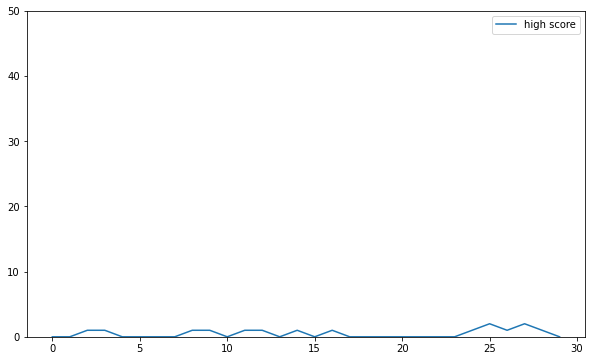

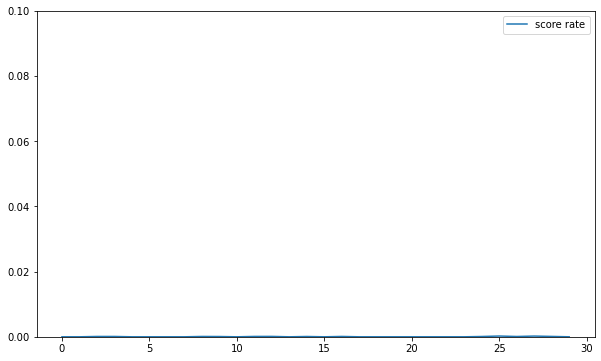

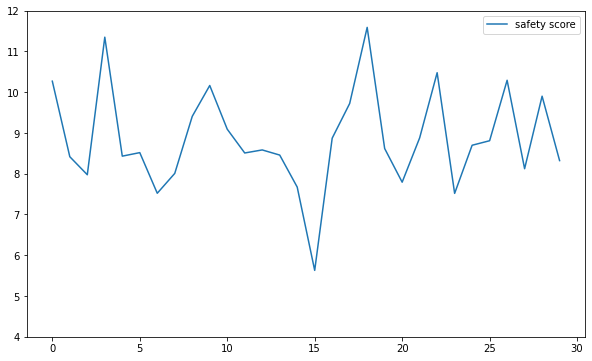

In [1]:
#Necessary Dependencies:
#pip install gym_tetris
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import MOVEMENT
import numpy as np
import matplotlib.pyplot as plt
import time



    
    
        

class Agent:
    
    def __init__(self, exp_rate=0.1, lr=0.1, n_steps=5, episodes=1):
        self.env = gym_tetris.make('TetrisA-v2',deterministic = True)
        self.env = JoypadSpace(self.env, MOVEMENT)
        #self.env.deterministic = True
        #Testing to see whether using the pixels for the state works better than just the board.
        #self.state = self.env.reset()
        self.env.reset()
        #self.env.deterministic = True
        self.env.render()
        self.state = tuple([ColorBoardtoSimpleBoard(self.env.ram[0x0400:0x04C8].reshape((20, 10)).copy()), "", "", tuple(self.env.ram[0x0040:0x0042])])

        self.highscore = 0
        self.time = 0
        self.linestates = []
        self.listofhighscores = []
        self.listofhighscorerates = []
        self.listofsafetyscores = []
        
        self.actions = MOVEMENT
        self.state_actions = []  # state & action track
        self.exp_rate = exp_rate
        self.lr = lr
        
        self.steps = n_steps
        self.episodes = episodes  # number of episodes going to play
        self.steps_per_episode = []
        
        self.Q_values = {}
        # model function
        self.model = {}

        #print(tuple(self.state))

        #Conversion of self.state to tuple for hashing purposes
        #self.state = tuple([tuple([tuple(y) for y in x]) for x in self.state])

        #print(self.state)
        #for x in self.state:
        #    print(hash(x))
        #print(type(self.state))
        #print(hash(self.state))
        
        #Only setup the Q-table for the initial state, the rest will be done as the game is played (far too many states to setup all of them)
        #print(type(self.state))
        #print(type(self.state[0]))
        self.Q_values[self.state] = {}
        for a in self.actions:
            #print(type(self.state))
            #print(type(a))
            self.Q_values[self.state][tuple(a)] = 0
        #
        #for row in range(ROWS):
        #    for col in range(COLS):
        #        self.Q_values[(row, col)] = {}
        #        for a in self.actions:
        #            self.Q_values[(row, col)][a] = 0
        
    def chooseAction(self):
        # epsilon-greedy
        mx_nxt_reward = -999
        action = ""
        
        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            current_position = self.state
            # if all actions have same value, then select randomly
            if len(set(self.Q_values[current_position].values())) == 1:
                action = np.random.choice(self.actions)
            else:
                for a in self.actions:
                    nxt_reward = self.Q_values[current_position][tuple(a)]
                    if nxt_reward >= mx_nxt_reward:
                        action = a
                        mx_nxt_reward = nxt_reward
        return action
    
    def reset(self):
        self.env.close()
        self.env = gym_tetris.make('TetrisA-v2',deterministic = True)
        self.env = JoypadSpace(self.env, MOVEMENT)
        self.env.deterministic = True
        #self.state = self.env.reset()
        #self.state = tuple([tuple([tuple(y) for y in x]) for x in self.state])
        self.env.reset()
        self.env.deterministic = True
        self.env.render()
        self.state = tuple([ColorBoardtoSimpleBoard(self.env.ram[0x0400:0x04C8].reshape((20, 10)).copy()), "", "", tuple(self.env.ram[0x0040:0x0042])])
        #Conversion of self.state to tuple for hashing purposes
        #self.state = tuple([tuple(x) for x in self.state])
        self.state_actions = []
        self.highscore = 0
        self.time = 0
        self.linestates = []

    #ToEdit
    def play(self):
        self.steps_per_episode = []  
        
        for ep in range(self.episodes):
            done = False
            while not done:

                action = tuple(self.chooseAction())
                self.state_actions.append((self.state, action))

                unusedstate, reward, done, info = self.env.step(self.env.action_space.sample())
                
                
                self.env.render()
                nxtState = tuple([ColorBoardtoSimpleBoard(self.env.ram[0x0400:0x04C8].reshape((20, 10)).copy()), info["current_piece"], info["next_piece"], tuple(self.env.ram[0x0040:0x0042])])
                #print(self.env.ram[0x0040:0x0042])
                #nxtState = unusedstate
                #nxtState = tuple([tuple([tuple(y) for y in x]) for x in nxtState])
                #Using custom rewards to guide the algorithm towards line clears
                #reward = CustomRewards(self.state,nxtState,reward)
                #Conversion of nxtState to tuple for hashing purposes
                #nxtState = tuple([tuple(x) for x in nxtState])
                self.highscore = info["score"]
                self.time += 1
                self.linestates.append(info["board_height"])
                #if self.time % 300 == 0:
                #    print(nxtState[0])
                #    print()
                #    time.sleep(10)
                # update Q-values for the nxtState
                if nxtState not in self.Q_values.keys():
                    self.Q_values[nxtState] = {}
                    for a in self.actions:
                        self.Q_values[nxtState][tuple(a)] = 0
                
                self.Q_values[self.state][action] += self.lr*(reward + np.max(list(self.Q_values[nxtState].values())) - self.Q_values[self.state][action])

                # update model
                if self.state not in self.model.keys():
                    self.model[self.state] = {}
                self.model[self.state][action] = (reward, nxtState)
                self.state = nxtState

                

                # loop n times to randomly update Q-value
                for _ in range(self.steps):
                    # randomly choose an state
                    rand_idx = np.random.choice(range(len(self.model.keys())))
                    _state = list(self.model)[rand_idx]
                    # randomly choose an action
                    rand_idx = np.random.choice(range(len(self.model[_state].keys())))
                    _action = tuple(list(self.model[_state])[rand_idx])

                    _reward, _nxtState = self.model[_state][_action]

                    self.Q_values[_state][_action] += self.lr*(_reward + np.max(list(self.Q_values[_nxtState].values())) - self.Q_values[_state][_action])       
            # end of game
            #if ep % 10 == 0:
            self.listofhighscores.append(self.highscore)
            self.listofhighscorerates.append(self.highscore / self.time)
            self.listofsafetyscores.append(sum(self.linestates) / self.time)
            print("episode", ep)
            print("Highscore: " + str(self.highscore))
            print("Score rate: " + str(self.highscore / self.time))
            print("Safety score: " + str(sum(self.linestates) / self.time))
            self.steps_per_episode.append(len(self.state_actions))
            self.reset()
if __name__ == "__main__":
    N_EPISODES = 30
    # comparison
    agent = Agent(n_steps=5, episodes=N_EPISODES)
    agent.play()

    highscores = agent.listofhighscores
    highscorerates = agent.listofhighscorerates
    safetyscores = agent.listofsafetyscores

    plt.figure(figsize=[10, 6])
    plt.ylim(0, 50)
    plt.plot(range(N_EPISODES), highscores, label="high score")
    plt.legend()
        
    plt.figure(figsize=[10, 6])
    plt.ylim(0, 0.1)
    plt.plot(range(N_EPISODES), highscorerates, label="score rate")
    plt.legend()
    
    plt.figure(figsize=[10, 6])
    plt.ylim(4, 12)
    plt.plot(range(N_EPISODES), safetyscores, label="safety score")
    plt.legend()

